In [1]:
import ms3
import pandas as pd
import os
import fractions
import seaborn as sns
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from random import randint

# DM 2022
# Assignment 1 - Discovering meter

## 0. General information

**Deadline:** 23.03 at 12h

**Deliverables:**
- *Code*: A Jupyter Notebook
- *Report:* A short report (max. 2 pages) as a Word document or other text file

**Submission:**
- Each group should create a **private** GitHub repository (shared with the tem members and the TAs) where data, code and report will be stored. Make sure your notebook is pushed with all output visible, i.e., in a form whereby we do not need to run the code.

---

*Since this is the first assignment, please make sure to share access to your repository with the TAs (GitHub handles: `GabrieleCecchetti` and `yrammos`) and to send the link by email (gabriele.cecchetti@epfl.ch) at any time before the deadline.*


# 1. Data

## Useful tools

- [MuseScore 3](https://musescore.org/en): a digital music-notation software. All scores in the corpus are encoded in MuseScore's native format `.mscx`, and you can use MuseScore to visualize the original scores in graphical notation.
- [ms3](https://johentsch.github.io/ms3/build/html/index.html): a parser for converting `.mscx` files into dataframes. 

## Corpus

For this project, you will be working with a corpus comprising the [Piano Sonatas by Wolfgang Amadeus Mozart](https://transactions.ismir.net/articles/10.5334/tismir.63/) and the [String Quartets by Ludwig van Beethoven](https://www.frontiersin.org/articles/10.3389/fdigh.2018.00016/full) transcribed in MuseScore 3 format (`.mscx`). 

The scores have been transcribed and published as part of the DCML coprus initiative and are available here:
- Mozart: https://github.com/DCMLab/mozart_piano_sonatas
- Beethoven: https://github.com/DCMLab/ABC/tree/v2

Classical sonatas and quartets are multi-part compositions that comprise several movements. Each file in the two sub-corpora contains one single movement: in this repertoire, sonatas typically comprise 3 movements and quartets typically comprise 4, but can also have more. For our purposes, each movement is essentially a piece of its own. 

#### Parsing the scores

In order to analyze the music computationally, we need to transform the information encoded in the score, which is a *human-readable* visual representation, into a *machine-readable* representation. MuseScore files are encoded in a XML format where each element of the score is identified by a number of features. Such format can be parsed into a dataframe, e.g., through the `ms3` library. 

For the purpose of this project, you will not need to take care of the parsing yourself: we have parsed the scores for you and you find the entire dataset in `.csv` format in this repository, under the name `DM2022 - Assignment 1 [Dataset].csv`. You can load the dataset as a `pandas` dataframe and work with it. 

Nevertheless, for completeness, we show here how parsing a score works.



In [2]:
corpus_folders = ['MozartSonatas/', 'BeethovenQuartets/']
scores = [subcorpus + piece for subcorpus in corpus_folders for piece in os.listdir(subcorpus) if '.mscx' in piece]

We can parse one score, e.g., the first movement of a Mozart's K282 Sonata, with the following commands in `ms3`:

In [3]:
#Parse the score in ms3
random_score = scores[randint(0,len(scores))]
s = ms3.Score(random_score, ms = 'auto')
print(random_score)
        
#Convert score into a list of notes
notes = s.mscx.notes
notes.head(10)

BeethovenQuartets/n10op74_03.mscx


,mc,mn,mc_onset,mn_onset,timesig,staff,voice,duration,nominal_duration,scalar,tied,tpc,midi,volta,chord_id
0,1,0,0,3/8,3/4,1,1,1/8,1/8,1,<NA>,0,72,<NA>,0
1,1,0,1/8,1/2,3/4,1,1,1/8,1/8,1,<NA>,0,72,<NA>,1
2,1,0,1/4,5/8,3/4,1,1,1/8,1/8,1,<NA>,0,72,<NA>,2
3,2,1,0,0,3/4,4,1,1/4,1/4,1,<NA>,0,36,<NA>,19
4,2,1,0,0,3/4,4,1,1/4,1/4,1,<NA>,0,48,<NA>,19
5,2,1,0,0,3/4,3,1,1/8,1/8,1,<NA>,0,60,<NA>,13
6,2,1,0,0,3/4,1,1,3/8,1/4,3/2,<NA>,0,60,<NA>,3
7,2,1,0,0,3/4,2,1,1/8,1/8,1,<NA>,-3,63,<NA>,7
8,2,1,1/8,1/8,3/4,3,1,1/8,1/8,1,<NA>,2,62,<NA>,14
9,2,1,1/8,1/8,3/4,2,1,1/8,1/8,1,<NA>,-1,65,<NA>,8


# Dataset

As mentioned above, you will not need to parse the scores yourselves for this assignment. You find the ready-to-use dataset under the name `DM2022 - Assignment 1 [Dataset].csv`. Note that, for each note in the dataset, we have computed its distance from the beginning of the piece, `global_onset` (measured in quarter-note units), and we have instead removed information about the bars (e.g., the measure number `mn`, or the onsets relative to the barlines, `mn_onset`). 


In [5]:
meter_dataset = pd.read_csv('DM2022 - Assignment 1 [Dataset].csv', index_col = 0, converters = {'global_onset':fractions.Fraction, 'duration': fractions.Fraction})
meter_dataset

,piece,notes_id,timesig,global_onset,staff,voice,duration,nominal_duration,scalar,tied,gracenote,midi
0,n01op18-1_01,0,3/4,0,3,1,1/4,1/4,1,1.0,NaN,53
1,n01op18-1_01,1,3/4,0,4,1,1/4,1/4,1,1.0,NaN,53
2,n01op18-1_01,2,3/4,0,1,1,1/4,1/4,1,1.0,NaN,65
3,n01op18-1_01,3,3/4,0,2,1,1/4,1/4,1,1.0,NaN,65
4,n01op18-1_01,4,3/4,1,3,1,1/8,1/8,1,-1.0,NaN,53
...,...,...,...,...,...,...,...,...,...,...,...,...
344698,K576-3,2415,2/4,375,1,1,1/8,1/8,1,NaN,NaN,69
344699,K576-3,2416,2/4,375,1,1,1/8,1/8,1,NaN,NaN,78
344700,K576-3,2417,2/4,376,2,1,1/4,1/4,1,NaN,NaN,50
344701,K576-3,2418,2/4,376,1,1,1/4,1/4,1,NaN,NaN,66


In [8]:
meter_dataset[meter_dataset.global_onset  < 0 ]

,piece,notes_id,timesig,global_onset,staff,voice,duration,nominal_duration,scalar,tied,gracenote,midi


Each row in the `meter_dataset` dataframe corresponds to one note event:
- **`piece`** - identifier of the piece: `SubCorpus/PieceName`
- **`notes_id`** - unique note identifier within each piece
- **`timesig`** - time signature
- **`global_onset`** - timestamp of the note's onset with respect to the beginning of the first bar of a piece, expressed in quarter-note units
- **`staff`** - staff to which the note belongs. In the piano sonatas, there are two staves (left and right hand); in the string quartets, there are four (violin I, violin II, viola and cello).
- **`voice`** - voice (within a staff) to which the note belongs
- **`duration`** - duration of the note, expressed as a fraction of a whole note
- **`nominal_duration`** - nominal durational value of the note type as notated in the score: for example, a dotted quarter note would have `duration`=3/8 yet `nominal_duration`=1/4, and each note in an eigth-note triplet would have `duration`=1/12 yet `nominal_duration`=1/8
- **`scalar`** - scaling factor between `nominal_duration` and `duration`: in other words,  `duration` = `nominal_duration`*`scalar`
- **`tied`** - if not `nan`, encodes whether the note is tied to the left (-1), to the right (1) or both (0)  
- **`gracenote`** - encodes whether the note is a grace note
- **`tpc`** - encodes the pitch class of the note: 0 is C, moving by one integer corresponds to moving by a fifth (e.g., +1 = G, -1 = F). Enharmonic pitch classes have different tpc values (e.g., $+7 = C\sharp \neq D\flat = -5$)
- **`midi`** - encodes the pitch of the note in midi format: 60 = C4, and moving by one integer corresponds to moving by one semitone (note that the midi format does not distinguish between enharmonically equivalent pitches, so that, e.g., 61 corresponds to both C#4 and Db4)


# 2. Task

The task for this project is to implement a data-driven approach to infer the time signatures from a dataset of symbolically-encoded music. Note that the ground-truth `timesig` is included in the dataset and can be useful for implementing a supervised classification approach, as well as to evaluate the outcomes. 

Try to quantify statistically the effectiveness of the classification. Is the classification equally confident with all pieces? In the report, try to motivate the approach you adopted, discuss why it resulted in the observed outcome (e.g., why did it fail on some specific pieces, or why did it work 100% of the time, or why did it work very poorly), and how it could be improved/generalized. 

### 2.1 Breaking down the task

(1) **Music $\rightarrow$ Metrical weights:** How to estimate the metrical weights from the music?

(2) **Metrical weights $\rightarrow$ Time signature:** How to infer the time signature from the metrical grid?

### 2.1.1 Music $\rightarrow$ Metrical weights

![Ex1](RhythmExample.png "Ex. 1")

e.g., $$ w(t)\propto \sum_{n|onset(n) = t} duration(n)  $$

### 2.1.2 Metrical weights $\rightarrow$ Time signature

Let us take the quarter note as our unit of duration, and the 16-th note level as the sampling rate of our grid.

In [2]:
#We take the quarter-note as our unit of duration
UNIT = 1/4

#We sample our grid every sixteenth-note 
sampling_period = 1/16

As an example, let us define some arbitrary metrical grid for one bar in a given time signature by assigning a metrical weight to each point in the grid (i.e., every 16-th note inside one bar gets its own metrical weight)...

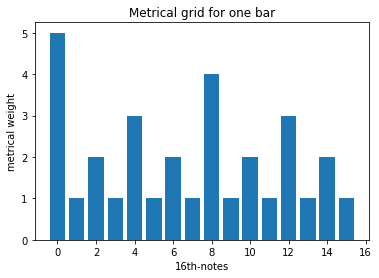

In [3]:
#We define the metrical grid for one bar...
metrical_grid = [5, 1, 2, 1, 3, 1, 2, 1, 4, 1, 2, 1, 3, 1, 2, 1] #This metrical grid could be considered a "prototype" for a 4/4 time signature
plt.bar(x = range(len(metrical_grid)), height = metrical_grid);
plt.title('Metrical grid for one bar');
plt.xlabel('16th-notes');
plt.ylabel('metrical weight');

... and build the metrical grid for an entire (fake) piece by concatenating many bars with the same metrical grid.

In [4]:
#... and we build the metrical grid for an entire (fake) piece by concatenating 100 bars 
n_bars = 100
fake_piece = metrical_grid * n_bars

In order to the time signature, we may wonder what periodicities are most salient in this fake piece. For example, we may wonder if a periodicity of 1.5 quarter-notes 

In [20]:
test_periodicity = 2

We build a "test" metrical grid where only the test periodicity is represented:

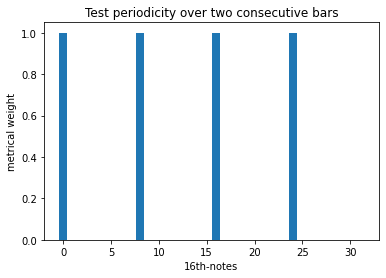

In [21]:
test_periodicity_grid = [1]+[0]*int((test_periodicity/(sampling_period/UNIT))-1)

plt.bar(x = range(len(metrical_grid*2)), height = [test_periodicity_grid[i%len(test_periodicity_grid)] for i in range(len(metrical_grid*2))]);
plt.title('Test periodicity over two consecutive bars');
plt.xlabel('16th-notes');
plt.ylabel('metrical weight');


Let's now extend the periodicity for the entire duration of the fake piece...

In [22]:
test_for_fake_piece = [test_periodicity_grid[i%len(test_periodicity_grid)] for i in range(len(fake_piece))]

... and compute the correlation between the test periodicity and the metrical grid of the fake piece:

In [23]:
pearsonr(fake_piece, test_for_fake_piece)[0]

0.8089129806094847

This is a (pretty naive) measure of how well the peaks of the test periodicity matche the peaks of the metrical grid. What changes if we try other periodicities? How could we leverage this information to infer the time signature that underlies the artificial metrical grid? **Note**: this is just a mock example, surely there are better ways!

### 2.2 Working with the data

As an example, let's focus on one single piece for now, e.g., the first movement of Mozart's K309.

In [28]:
one_piece = meter_dataset[meter_dataset.piece == 'K282-1']
one_piece[:60]

,piece,notes_id,timesig,global_onset,staff,voice,duration,nominal_duration,scalar,tied,gracenote,midi
253825,K282-1,0,4/4,0,2,2,1/4,1/4,1,NaN,NaN,63
253826,K282-1,1,4/4,0,2,1,1/4,1/4,1,NaN,NaN,67
253827,K282-1,2,4/4,0,1,1,3/16,1/8,3/2,NaN,NaN,70
253828,K282-1,3,4/4,3/4,1,1,1/16,1/16,1,NaN,NaN,72
253829,K282-1,4,4/4,1,2,2,1/4,1/4,1,NaN,NaN,63
253830,K282-1,5,4/4,1,2,1,1/4,1/4,1,NaN,NaN,67
253831,K282-1,6,4/4,1,1,1,1/4,1/4,1,1.0,NaN,70
253832,K282-1,7,4/4,2,2,2,1/4,1/4,1,NaN,NaN,62
253833,K282-1,8,4/4,2,2,1,1/4,1/4,1,NaN,NaN,65
253834,K282-1,9,4/4,2,1,1,1/8,1/8,1,-1.0,NaN,70


Let's split our piece in sixteenth-note bins, and compute the average duration of events with onsets in each bin:

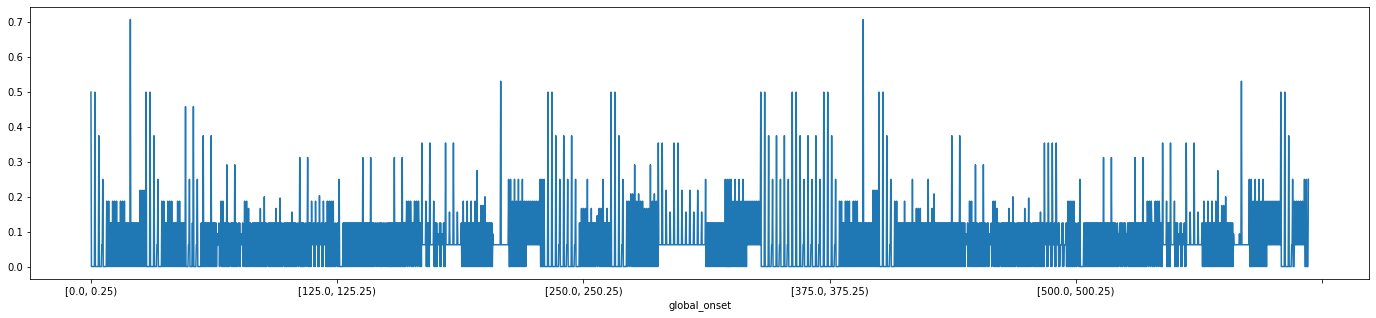

In [24]:
#We measure time in quarter-note units...
UNIT = 1/4
#And we bin time in sixteenth-note windows
sampling_period = 1/16

#Ignore grace notes (but, could they be useful?)
one_piece = one_piece[one_piece.gracenote.isna()]

#Compute the first and last bins
first_bin = np.floor(one_piece.global_onset.min()/(sampling_period/UNIT))*(sampling_period/UNIT)
last_bin = np.ceil((one_piece.global_onset.max() - first_bin) / (sampling_period / UNIT))

#Partition the global_onsets in bins
bins = [first_bin + (sampling_period / UNIT) * i for i in range(int(last_bin)+2)]
binned_onsets = pd.cut(one_piece['global_onset'], bins, right = False)

#Compute the average duration of events with onsets in each bin
binned_durations = one_piece.groupby(binned_onsets).duration.mean().fillna(0).apply(float)
binned_durations.plot(figsize=(24,5));

This plot represents a candidate estimate of the metrical grid for the given piece: how could one try to infer the time signature from this?

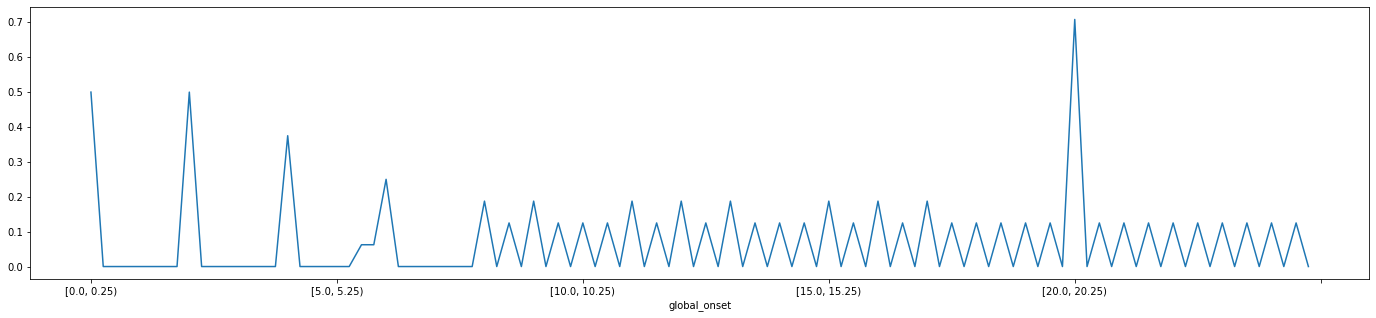

In [25]:
binned_durations[:100].plot(figsize=(24,5));